# Определение перспективного тарифа для телеком компании

# Цель проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». <br>
    Необходимо провести предварительный анализ тарифов и на основании полученных данных сделать вывод - какой тариф лучше. 

# Описание данных

Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 


Описание тарифов <br>
**Тариф «Смарт»** <br>
Ежемесячная плата: 550 рублей<br>
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.<br>
**Тариф «Ультра»**<br>
Ежемесячная плата: 1950 рублей<br>
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


**Описание таблиц**

**Таблица users (информация о пользователях):**<br>

user_id — уникальный идентификатор пользователя<br>
first_name — имя пользователя<br>
last_name — фамилия пользователя<br>
age — возраст пользователя (годы)<br>
reg_date — дата подключения тарифа (день, месяц, год)<br>
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)<br>
city — город проживания пользователя<br>
tarif — название тарифного плана<br>

**Таблица calls (информация о звонках):**<br>

id — уникальный номер звонка<br>
call_date — дата звонка<br>
duration — длительность звонка в минутах<br>
user_id — идентификатор пользователя, сделавшего звонок<br>

**Таблица messages (информация о сообщениях):**<br>

id — уникальный номер сообщения<br>
message_date — дата сообщения<br>
user_id — идентификатор пользователя, отправившего сообщение<br>

**Таблица internet (информация об интернет-сессиях):**<br>
id — уникальный номер сессии<br>
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)<br>
session_date — дата интернет-сессии<br>
user_id — идентификатор пользователя<br>

**Таблица tariffs (информация о тарифах):**<br>

tariff_name — название тарифа<br>
rub_monthly_fee — ежемесячная абонентская плата в рублях<br>
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату<br>
messages_included — количество сообщений в месяц, включённых в абонентскую плату<br>
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)<br>
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)<br>
rub_per_message — стоимость отправки сообщения сверх тарифного пакета<br>
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)<br>

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from functools import reduce
# import warnings

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Информация о звонках:

In [3]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Посмотрим на длительность звонков:

In [5]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Как видим, есть нулевые значения - скорее всего, это пропущенные звонки. Пропущенных значений нет - уже неплохо.
Надо будет перевести call_date в формат даты. <br>
В среднем длительность звонка составляет 6 минут, а самый долгий разговор длился 38 минут. 

Информация об интернет-сессиях:

In [6]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Тут, как и в звонках, есть нулевые значения, пропущенных данных нет, можно удалить столбец 'Unnamed 0' и перевести дату в удобный формат. <br>
Медианное значение - 348 мб, а максимальное - 1724 мб.  

In [9]:
del internet['Unnamed: 0']

Информация о сообщениях:

In [10]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Тут все неплохо - пропущенных значений нет, только формат даты изменить.

Тарифы:

In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


На первый взгляд тут все хорошо.

И наконец информация о пользователях:

In [14]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Для удобства изменим название столбца с названием тарифа:

In [15]:
users = users.rename(columns = { 'tariff': 'tariff_name'})

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id        500 non-null int64
age            500 non-null int64
churn_date     38 non-null object
city           500 non-null object
first_name     500 non-null object
last_name      500 non-null object
reg_date       500 non-null object
tariff_name    500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Тут есть пропуски в churn_date, но все под контролем - если значение пропущено, то тариф ещё действовал на момент выгрузки данных.


И сразу проверим данные в колонке age:

In [17]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Все в порядке, аномальных значений нет. Самому молодому абоненту - 18 лет, а самому пожилому - 75. 

### Вывод

Посмотрели на данные - какие данные есть, какой формат, есть ли пропущенные значения. В таблице calls и internet есть нулевые значения.

## Предобработка данных

Переведем данные в правильный формат:

In [18]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

Т.к. дальше нам надо будет посчитать данные по месяцам, создадим отдельную колонку:

In [19]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
users['reg_date_month'] = pd.DatetimeIndex(users['reg_date']).month 
users['churn_date_month'] = pd.DatetimeIndex(users['churn_date']).month 

На этапе предварительного изучения данных мы заметили, что в таблице со звонками были нулевые значения. Посмотрим, сколько их относительно всех данных:

In [20]:
print('Всего нулевых значений: {:.2%}'.format(len(calls[calls['duration'] == 0])/len(calls)))

Всего нулевых значений: 19.55%


Почти 20% звонков с нулевой длительностью. Это могут быть пропущенные звонки, которые сохраняются в системе как звонки с нулевой продолжительностью, либо какой-то сбой в системе, когда длительность звонков удалилась или не записалась. <br>
Т.к. 20% данных - это довольно много для их бездумного удаления, оставим, как есть - с пометкой в общем выводе, что надо дополнительно проверить данные - не было ли сбоев в системе. 

Нулевые значения в таблице с данными об интернет-траффике:

In [21]:
print('Всего нулевых значений: {:.2%}'.format(len(internet[internet['mb_used'] == 0])/len(internet)))

Всего нулевых значений: 13.12%


А тут 13% - меньше, чем нулевых значений в звонках, но все равно много. Удалять мы их не будем.
Тут, скорее всего, тоже или сбой в системе - данные либо удалились, либо не записались, или система определяет неудачные сессии (или просто подключение к интернету без совершения как-либо действий) как полноценные сессии. 


Кроме это надо округлить продолжительность звонков и количество использованного траффика в большую сторону (т.к. - «Мегалайн» всегда округляет вверх значения минут):

In [22]:
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))

### Вывод

Привели данные к удобному формату, месяц вывели в отдельную колонку. Проверили соотношение нулевых данных в таблицах, сделали предположение, из-за чего такое могло произойти. <br>
Округлили данные о длительности звонков.

## Расчёты и добавление результатов в таблицу

**Посчитайте для каждого пользователя:  <br>
количество сделанных звонков и израсходованных минут разговора по месяцам;<br>
количество отправленных сообщений по месяцам;<br>
объем израсходованного интернет-трафика по месяцам;<br>
помесячную выручку с каждого пользователя.**

Для каждого пользователя посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам:

In [23]:
calls_by_month = calls.groupby(['user_id', 'month']).agg({'duration' : 'sum', 'id' : 'count'}).reset_index()
calls_by_month.columns = ['user_id', 'month', 'total_duration', 'cnt_calls']
calls_by_month

,user_id,month,total_duration,cnt_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


То же сделаем для подсчета сообщений за месяц:

In [24]:
messages_by_month = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()
messages_by_month.columns = ['user_id', 'month', 'cnt_messages']
messages_by_month

,user_id,month,cnt_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Объем израсходованного интернет-трафика по месяцам:


In [25]:
internet_by_month = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet_by_month

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Количество мегабайт также округлим в бОльшую сторону:

In [26]:
internet_by_month['mb_used'] = np.ceil(internet_by_month['mb_used'])
internet_by_month

,user_id,month,mb_used
0,1000,5,2254.0
1,1000,6,23234.0
2,1000,7,14004.0
3,1000,8,14056.0
4,1000,9,14569.0
...,...,...,...
3198,1498,10,20580.0
3199,1499,9,1846.0
3200,1499,10,17789.0
3201,1499,11,17964.0


Объединим данные в одну таблицу:

In [27]:
data_by_months = pd.merge(calls_by_month, messages_by_month, how = 'outer',  on = ['month', 'user_id'])

In [28]:
data_by_months = pd.merge(data_by_months, internet_by_month, how = 'outer', on = ['month', 'user_id'])

In [29]:
data_by_months

,user_id,month,total_duration,cnt_calls,cnt_messages,mb_used
0,1000,5,159.0,22.0,22.0,2254.0
1,1000,6,172.0,43.0,60.0,23234.0
2,1000,7,340.0,47.0,75.0,14004.0
3,1000,8,408.0,52.0,81.0,14056.0
4,1000,9,466.0,58.0,57.0,14569.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17207.0
3210,1489,10,NaN,NaN,21.0,19560.0
3211,1489,11,NaN,NaN,20.0,17492.0
3212,1489,12,NaN,NaN,35.0,17323.0


In [30]:
# data_by_months[data_by_months.isna().any(axis=1)]
# data_by_months['total_duration'].isna().sum()
# data_by_months['cnt_calls'].isna().sum()
data_by_months['cnt_messages'].isna().sum()

497

А вот тут уже появились пропущенные значения - скорее всего, пользователи просто предпочитают интернет звонкам или сообщения звонкам. 

Объединяем данные с таблицей users:

In [31]:
user_data_by_months = pd.merge(data_by_months, users, how = 'left', on = 'user_id')
user_data_by_months

,user_id,month,total_duration,cnt_calls,cnt_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,reg_date_month,churn_date_month
0,1000,5,159.0,22.0,22.0,2254.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1000,6,172.0,43.0,60.0,23234.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
2,1000,7,340.0,47.0,75.0,14004.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
3,1000,8,408.0,52.0,81.0,14056.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
4,1000,9,466.0,58.0,57.0,14569.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17207.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,NaN
3210,1489,10,NaN,NaN,21.0,19560.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,NaN
3211,1489,11,NaN,NaN,20.0,17492.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,NaN
3212,1489,12,NaN,NaN,35.0,17323.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,NaN


И добавляем данные по тарифам:

In [32]:
user_data_by_months = pd.merge(user_data_by_months, tariffs, how = 'left', on = 'tariff_name')
user_data_by_months

,user_id,month,total_duration,cnt_calls,cnt_messages,mb_used,age,churn_date,city,first_name,...,tariff_name,reg_date_month,churn_date_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2254.0,52,NaT,Краснодар,Рафаил,...,ultra,5,NaN,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23234.0,52,NaT,Краснодар,Рафаил,...,ultra,5,NaN,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14004.0,52,NaT,Краснодар,Рафаил,...,ultra,5,NaN,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14056.0,52,NaT,Краснодар,Рафаил,...,ultra,5,NaN,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14569.0,52,NaT,Краснодар,Рафаил,...,ultra,5,NaN,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17207.0,35,NaT,Санкт-Петербург,Павел,...,smart,8,NaN,50,15360,500,550,200,3,3
3210,1489,10,NaN,NaN,21.0,19560.0,35,NaT,Санкт-Петербург,Павел,...,smart,8,NaN,50,15360,500,550,200,3,3
3211,1489,11,NaN,NaN,20.0,17492.0,35,NaT,Санкт-Петербург,Павел,...,smart,8,NaN,50,15360,500,550,200,3,3
3212,1489,12,NaN,NaN,35.0,17323.0,35,NaT,Санкт-Петербург,Павел,...,smart,8,NaN,50,15360,500,550,200,3,3


Посчитаем помесячную выручку с каждого пользователя.
Посчитаем, сколько абоненты потратили на сообщения сверх нормы:

In [33]:
user_data_by_months['over_messages'] = (user_data_by_months['cnt_messages'] - user_data_by_months['messages_included'])*user_data_by_months['rub_per_message']
user_data_by_months['over_messages'] = user_data_by_months['over_messages'].apply(lambda x: 0 if x < 0 else x)
user_data_by_months['over_messages']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3209    0.0
3210    0.0
3211    0.0
3212    0.0
3213    NaN
Name: over_messages, Length: 3214, dtype: float64

То же - для "лишних" минут:

In [34]:
user_data_by_months['over_calls'] = (user_data_by_months['total_duration'] - user_data_by_months['minutes_included'])*user_data_by_months['rub_per_minute']
user_data_by_months['over_calls'] = user_data_by_months['over_calls'].apply(lambda x: 0 if x < 0 else x)
user_data_by_months['over_calls']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3209    NaN
3210    NaN
3211    NaN
3212    NaN
3213    NaN
Name: over_calls, Length: 3214, dtype: float64

И для мегабайт (перевели в Гб):

In [35]:
user_data_by_months['over_mb'] = (user_data_by_months['mb_used'] - user_data_by_months['mb_per_month_included'])/1024*user_data_by_months['rub_per_gb']
user_data_by_months['over_mb'] = user_data_by_months['over_mb'].apply(lambda x: 0 if x < 0 else x)
user_data_by_months['over_mb']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
3209    360.742188
3210    820.312500
3211    416.406250
3212    383.398438
3213      0.000000
Name: over_mb, Length: 3214, dtype: float64

Посчитаем, сколько абонент всего тратит на связь:

In [36]:
user_data_by_months['total_profit'] = user_data_by_months['over_calls'] + user_data_by_months['over_mb'] + user_data_by_months['over_messages'] + user_data_by_months['rub_monthly_fee']
user_data_by_months

,user_id,month,total_duration,cnt_calls,cnt_messages,mb_used,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_messages,over_calls,over_mb,total_profit
0,1000,5,159.0,22.0,22.0,2254.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.000000,1950.0
1,1000,6,172.0,43.0,60.0,23234.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.000000,1950.0
2,1000,7,340.0,47.0,75.0,14004.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.000000,1950.0
3,1000,8,408.0,52.0,81.0,14056.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.000000,1950.0
4,1000,9,466.0,58.0,57.0,14569.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.000000,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17207.0,35,NaT,Санкт-Петербург,Павел,...,15360,500,550,200,3,3,0.0,NaN,360.742188,NaN
3210,1489,10,NaN,NaN,21.0,19560.0,35,NaT,Санкт-Петербург,Павел,...,15360,500,550,200,3,3,0.0,NaN,820.312500,NaN
3211,1489,11,NaN,NaN,20.0,17492.0,35,NaT,Санкт-Петербург,Павел,...,15360,500,550,200,3,3,0.0,NaN,416.406250,NaN
3212,1489,12,NaN,NaN,35.0,17323.0,35,NaT,Санкт-Петербург,Павел,...,15360,500,550,200,3,3,0.0,NaN,383.398438,NaN


### Вывод

Для каждого абонента посчитали, сколько он тратит на связь в месяц. 

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Посмотрим средние значения для каждого тарифа:

In [37]:
tariff_data = round(user_data_by_months.pivot_table(index = ['tariff_name', 'month'], values = ['total_duration', 'cnt_calls', 'cnt_messages', 'mb_used', 'total_profit']).reset_index())
tariff_data.head(10)

,tariff_name,month,cnt_calls,cnt_messages,mb_used,total_duration,total_profit
0,smart,1,28.0,20.0,8514.0,204.0,713.0
1,smart,2,40.0,28.0,11598.0,299.0,800.0
2,smart,3,54.0,36.0,15105.0,390.0,1078.0
3,smart,4,51.0,36.0,13463.0,367.0,932.0
4,smart,5,55.0,39.0,15806.0,387.0,1167.0
5,smart,6,56.0,39.0,15795.0,398.0,1154.0
6,smart,7,57.0,39.0,15744.0,408.0,1169.0
7,smart,8,59.0,39.0,16682.0,423.0,1292.0
8,smart,9,60.0,39.0,16304.0,430.0,1206.0
9,smart,10,60.0,39.0,16758.0,428.0,1305.0


In [38]:
tariff_data_year = round(tariff_data.groupby('tariff_name').mean()).reset_index()
tariff_data_year

,tariff_name,month,cnt_calls,cnt_messages,mb_used,total_duration,total_profit
0,smart,6.0,54.0,36.0,15065.0,388.0,1130.0
1,ultra,6.0,71.0,55.0,18427.0,511.0,2021.0


В среднем на тарифе Смарт и звонков больше (и их общая длительность), и сообщений, и количество потраченных мегабайт.

Для удобства разделим датафреймы на два:

In [39]:
smart_tariff = tariff_data[tariff_data['tariff_name']=='smart']
ultra_tariff = tariff_data[tariff_data['tariff_name']=='ultra']
# smart_tariff

Дисперсия для тарифа Смарт:

In [40]:
np.var(smart_tariff).apply(lambda x: format(x, 'f'))

month                  11.916667
cnt_calls             102.076389
cnt_messages           35.388889
mb_used           6559311.409722
total_duration       4847.909722
total_profit        44107.250000
dtype: object

Дисперсия для тарифа Ультра:

In [41]:
np.var(ultra_tariff).apply(lambda x: format(x, 'f'))

month                  11.916667
cnt_calls             125.520833
cnt_messages          132.138889
mb_used           7524844.243056
total_duration       6593.138889
total_profit         1899.000000
dtype: object

Среднее отклонение для тарифа Смарт:

In [42]:
np.std(smart_tariff).apply(lambda x: format(x, 'f'))

month                3.452053
cnt_calls           10.103286
cnt_messages         5.948856
mb_used           2561.115267
total_duration      69.626932
total_profit       210.017261
dtype: object

Среднее отклонение для тарифа Ультра:

In [43]:
np.std(ultra_tariff).apply(lambda x: format(x, 'f'))

month                3.452053
cnt_calls           11.203608
cnt_messages        11.495168
mb_used           2743.144955
total_duration      81.198146
total_profit        43.577517
dtype: object

Напишем функцию для построения гистограмм:

In [44]:
def plotting(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,5))
    plt.title(title)
    sns.distplot(smart_tariff[column], label='Тариф Smart', kde=False)
    sns.distplot(ultra_tariff[column], label='Тариф Ultra', kde=False)
    plt.legend()

Распределение по кол-ву мегабайт:

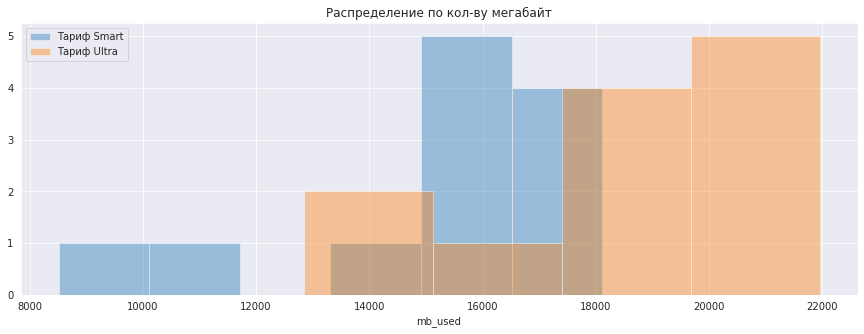

In [45]:
plotting('mb_used', 'Распределение по кол-ву мегабайт')

Распределение по кол-ву звонков:

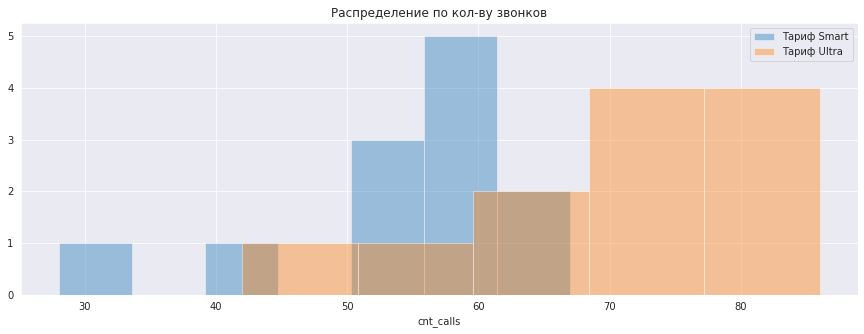

In [46]:
plotting('cnt_calls', 'Распределение по кол-ву звонков')

По кол-ву сообщений:

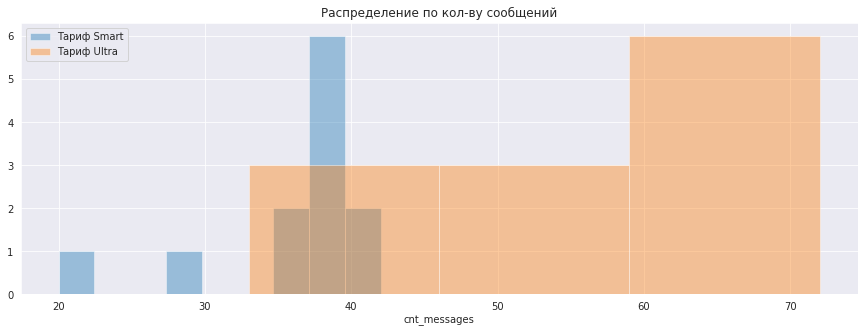

In [47]:
plotting('cnt_messages', 'Распределение по кол-ву сообщений')

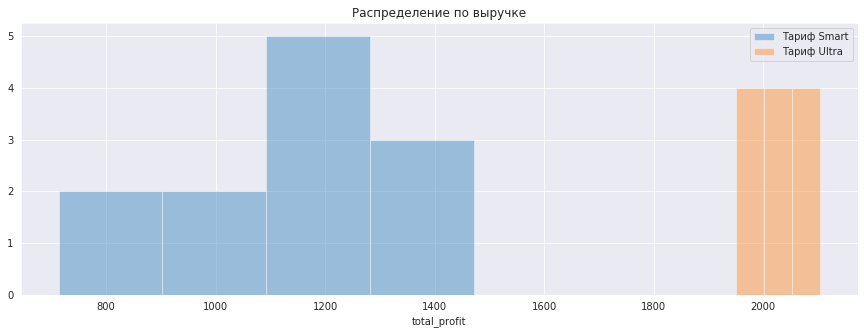

In [48]:
plotting('total_profit', 'Распределение по выручке')

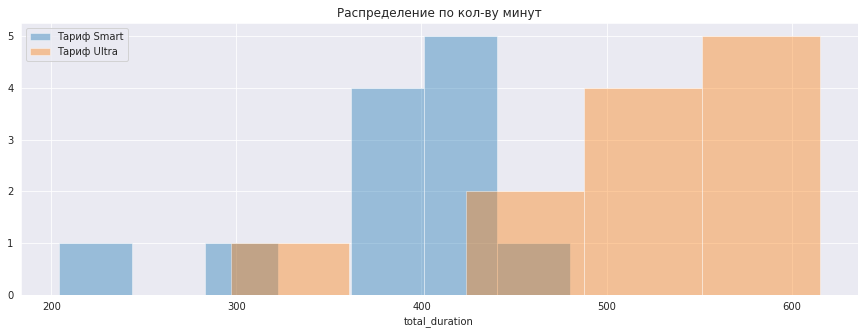

In [49]:
plotting('total_duration', 'Распределение по кол-ву минут')

### Вывод

Исходя из расчетов и гистрограмм можно сделать вывод, что: <br>
    1. Среднее кол-во сообщений на тарифе Ультра (55 против 36) <br>
    2. Среднее кол-во звонков также больше на тарифе Ультра (51 и 74) <br>
    4. Тратят мегабайты также больше на тарифе Ультра (около 15 гб на Смарте и 18 - на тарифе Ультра)  

Посмотрим общую выручку компании по тарифам:

Ранее мы считали, сколько в среднем за год абоненты тратят на связь:

In [50]:
tariff_data_year.head(10)

,tariff_name,month,cnt_calls,cnt_messages,mb_used,total_duration,total_profit
0,smart,6.0,54.0,36.0,15065.0,388.0,1130.0
1,ultra,6.0,71.0,55.0,18427.0,511.0,2021.0


Для удобства добавим сюда столбец с тарифной платой:

In [51]:
tariff_data_year['rub_monthly_fee'] = tariffs['rub_monthly_fee']

In [52]:
tariff_data_year['overpayment'] = round(1 - tariff_data_year['rub_monthly_fee']/tariff_data_year['total_profit'], 2)

In [53]:
tariff_data_year

,tariff_name,month,cnt_calls,cnt_messages,mb_used,total_duration,total_profit,rub_monthly_fee,overpayment
0,smart,6.0,54.0,36.0,15065.0,388.0,1130.0,550,0.51
1,ultra,6.0,71.0,55.0,18427.0,511.0,2021.0,1950,0.04


In [54]:
for i, row in tariff_data_year.iterrows():
    print('Для тарифа', row['tariff_name'], ' переплата в среднем составляет:', row['overpayment'])

Для тарифа smart  переплата в среднем составляет: 0.51
Для тарифа ultra  переплата в среднем составляет: 0.04


Казалось бы, для абонентов выгоднее брать тариф Ультра! Ведь средняя переплата там составляет всего 4%. <br>
Но даже учитывая переплаты, абоненты все равно платят за тариф почти в два раза меньше. 

Посмотрим, сколько прибыли приносят эти тарифы для компании:

In [55]:
tariff_data_income = user_data_by_months.pivot_table(index = 'tariff_name', values = 'total_profit', aggfunc = 'sum').reset_index()
tariff_data_income

,tariff_name,total_profit
0,smart,2.358273e+06
1,ultra,1.534252e+06


In [56]:
print(tariff_data_income.loc[0, 'total_profit']/tariff_data_income.loc[1, 'total_profit'])

1.5370826475765471


При этом прибыль от тарифа Смарт в полтора раза выше! 

### Вывод 

Проверили, что выгоднее: <br>
    1. Для пользователей выгоднее тариф Ультра - переплата на нем составляет около 4%, в то время как на тарифе Смарт абоненты переплачивают в 2 раза!<br>
    2. А вот для компании выгоднее продвигать тариф Смарт - он приносит компании в полтора раза больше денег.

Посчитаем, какой тариф популярнее:

In [57]:
users_tariff = pd.merge(users, tariffs, how = 'left', on = 'tariff_name')
users_tariff.groupby('tariff_name')['user_id'].count()

tariff_name
smart    351
ultra    149
Name: user_id, dtype: int64

351 абонент на Смарте, и 149 - на тарифе Ультра.

Тариф Смарт популярнее скорее всего из-за того, что он более дешевый:

In [58]:
tariffs[['tariff_name', 'rub_monthly_fee']]

,tariff_name,rub_monthly_fee
0,smart,550
1,ultra,1950


## Проверка гипотез

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Средняя выручка пользователей тарифов Смарт и Ультра не различается
- Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов Смарт и Ультра различается

In [59]:
smart_tariff = tariff_data[tariff_data['tariff_name']=='smart']
ultra_tariff = tariff_data[tariff_data['tariff_name']=='ultra']

smart_tariff

,tariff_name,month,cnt_calls,cnt_messages,mb_used,total_duration,total_profit
0,smart,1,28.0,20.0,8514.0,204.0,713.0
1,smart,2,40.0,28.0,11598.0,299.0,800.0
2,smart,3,54.0,36.0,15105.0,390.0,1078.0
3,smart,4,51.0,36.0,13463.0,367.0,932.0
4,smart,5,55.0,39.0,15806.0,387.0,1167.0
5,smart,6,56.0,39.0,15795.0,398.0,1154.0
6,smart,7,57.0,39.0,15744.0,408.0,1169.0
7,smart,8,59.0,39.0,16682.0,423.0,1292.0
8,smart,9,60.0,39.0,16304.0,430.0,1206.0
9,smart,10,60.0,39.0,16758.0,428.0,1305.0


In [60]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = .05

results = st.ttest_ind(ultra_tariff['total_profit'], smart_tariff['total_profit'], equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0864423647978654e-08
Отвергаем нулевую гипотезу


#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Сформулируем нулевые гипотезы :

- Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- Альтернативная гипотеза H₁: Средняя выручка пользователей ииз Москвы отличается от выручки пользователей из других регионов

In [61]:
tariff_data_city = round(user_data_by_months.pivot_table(index = ['user_id', 'city'], values = 'total_profit').reset_index())
tariff_data_city

,user_id,city,total_profit
0,1000,Краснодар,1950.0
1,1002,Стерлитамак,954.0
2,1003,Москва,1950.0
3,1004,Новокузнецк,1950.0
4,1005,Набережные Челны,827.0
...,...,...,...
414,1495,Иркутск,2260.0
415,1496,Вологда,2278.0
416,1497,Челябинск,892.0
417,1498,Владикавказ,1578.0


In [62]:
tariff_data_moscow = tariff_data_city[tariff_data_city['city'] == 'Москва'].total_profit
tariff_data_other_city = tariff_data_city[tariff_data_city['city'] != 'Москва'].total_profit
tariff_data_other_city.mean()

1502.213649851632

In [63]:
alpha = .05

results = st.ttest_ind(tariff_data_moscow, tariff_data_other_city, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7991100723504931
Не получилось отвергнуть нулевую гипотезу


### Вывод

Проверили две гипотезы: <br>
    1. Средняя выручка пользователей тарифов Смарт и Ультра действительно различается <br>
    2. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

## Общий вывод

Проанализировали данные по двум тарифам: <br>

**Общие сведения:** <br>
Средняя продолжительность разговоров в месяц на тарифе Смарт составляет 388 минут, а на тарифе Ультра - 511. <br>
Среднее кол-во сообщений на тарифе Смарт - 36, на тарифе Ультра  - 55. <br>
Среднее кол-во звонков также больше на тарифе Ультра (51 и 74) <br>
Тратят мегабайты также больше на тарифе Ультра (около 15 гб на Смарте и 18 - на тарифе Ультра)  <br>

**Также проверили две гипотезы и сделали следующие выводы:**<br>

1. Средняя выручка пользователей тарифов Смарт и Ультра действительно различается<br>
2. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

Кроме того, были обнаружены нулевые значения в таблицах (продолжительность звонков и количество потраченных мегабайт), что может свидетельствовать о возможных сбоях в системе. 

**Выводы о выгодности тарифов:**
1. Несмотря на то, что переплата на тарифе Ультра составляет всего 4% против почти 50% на тарифе Смарт, абонентская плата на Смарте все равно выходит почти в два раза дешевле. <br>
2. На первый взгляд, для компании более выгоден тариф Смарт - ведь он приносит в полтора раза больше прибыли. 
Но тарифом Ультра пользуется куда меньше людей (149 против 351)<br>

Кажется, что не хватает среднего между этими двумя тарифами:
1. Тарифа Ультра, конечно, почти всегда хватает, но он и стоит почти в 4 раза дороже, чем тариф Смарт (1950 против 550 рублей за тариф Смарт в месяц)
2. Абонентам Смарта довольно часто не хватает включенных в тариф звонков, сообщений и трафика - в среднем абонент Смарта тратит на связь около тысячи рублей.
3. Выходит, что Ультра - это слишком, а Смарт - недостаточно. <br>
Не хватает золотой середины. Думаю, это может стать перспективным направлением. 
